# **2. Predictive AI: CNN for Compliance Prediction**

![CNN](https://drive.google.com/uc?id=11jjdlSmA0NxVcY2DyQeqIRZMrXyqyxC8)
**Overview**:  

1) Import libraries and define parameters.  
2) Load and preprocess a dataset of images along with compliance labels.  
3) Define a Convolutional Neural Network (CNN) for predicting two compliance
values.  
4) Train and evaluate the CNN model.  
5) Visualize results.  


## 1) Import Libraries and Environment Setup

### **| Load dataset**

In [1]:
!gdown 1cG5p-tX5KV9RJyXovdr9gJnxiX0twh2k -O DDIM_Generated_images.zip
!mkdir -p DDIM_Generated_images
!unzip -q DDIM_Generated_images.zip -d DDIM_Generated_images
!ls ./DDIM_Generated_images

Downloading...
From: https://drive.google.com/uc?id=1cG5p-tX5KV9RJyXovdr9gJnxiX0twh2k
To: /content/DDIM_Generated_images.zip
100% 206k/206k [00:00<00:00, 35.7MB/s]
compliance_label.csv  inference_025.png  inference_053.png  inference_078.png
inference_001.png     inference_026.png  inference_054.png  inference_079.png
inference_002.png     inference_027.png  inference_055.png  inference_080.png
inference_003.png     inference_028.png  inference_056.png  inference_082.png
inference_004.png     inference_030.png  inference_058.png  inference_083.png
inference_005.png     inference_031.png  inference_059.png  inference_084.png
inference_006.png     inference_032.png  inference_060.png  inference_086.png
inference_007.png     inference_033.png  inference_061.png  inference_087.png
inference_008.png     inference_036.png  inference_062.png  inference_088.png
inference_009.png     inference_037.png  inference_063.png  inference_090.png
inference_010.png     inference_038.png  inference_065.p

In [2]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import random

# Device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", device)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set a global seed for reproducibility
set_seed(1)

PyTorch version: 2.10.0+cu128
CUDA available: True
Device: cuda:0


### **| Define Parameters**


In [3]:
data_dir = './DDIM_Generated_images/'
batch_size = 256
epochs = 300
learning_rate = 2e-3
train_split = 0.8

## 2) Load and Preprocess Data
The **`ComplianceDataset`** class:
1. Reads a `compliance_label.csv` file.
2. Loads images (grayscale, `PNG` format).
3. Normalizes them to the range `[-1, 1]`.
4. Normalizes labels `(compliance1, compliance2)` to `[0, 1]`.
5. Returns `(image_tensor, label_tensor)`.

In [4]:
class ComplianceDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = data_dir
        # CSV file path
        csv_path = os.path.join(data_dir, 'compliance_label.csv')

        self.indices = []
        self.labels = []  # Will store (comp1, comp2)

        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader)  # Skip header
            for row in reader:
                index = int(row[0])
                comp1 = float(row[1])
                comp2 = float(row[2])
                self.indices.append(index)
                self.labels.append([comp1, comp2])

        self.labels = np.array(self.labels)

        # Normalize labels to [0, 1]
        self.labels_min = self.labels.min(axis=0)
        self.labels_max = self.labels.max(axis=0)
        self.labels = (self.labels - self.labels_min) / (self.labels_max - self.labels_min)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        # Image file name: inference_XXX.png
        img_path = os.path.join(self.data_dir, f"inference_{index:03d}.png")
        image = Image.open(img_path).convert('L')  # Grayscale
        image = np.array(image, dtype=np.float32)

        # Normalize image from [0, 255] to [-1, 1]
        image_tensor = torch.from_numpy(image).unsqueeze(0)  # shape: (1, H, W)
        image_tensor = (image_tensor / 127.5) - 1.0

        # Retrieve label
        label = self.labels[idx]
        label_tensor = torch.from_numpy(label).float()  # shape: (2,)

        return image_tensor, label_tensor

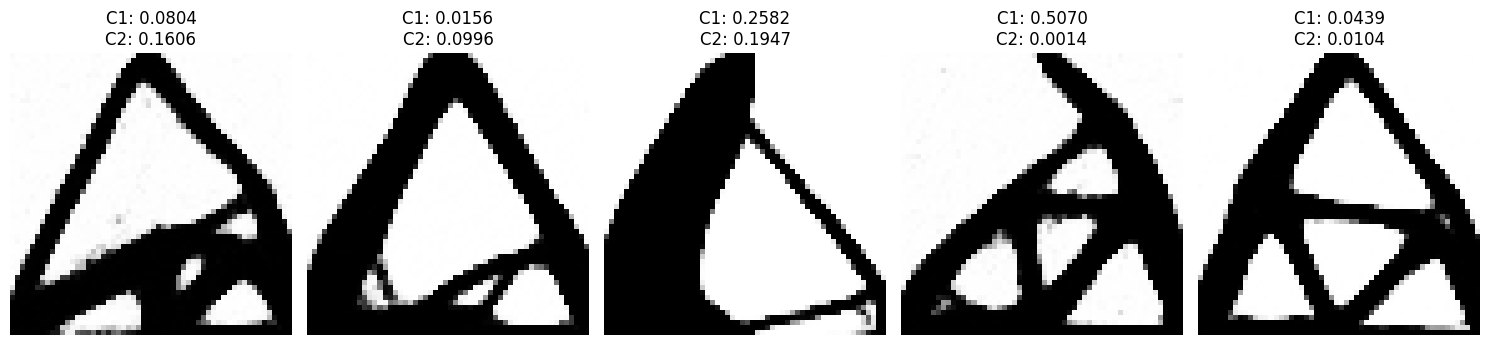

In [5]:
# Load dataset
dataset = ComplianceDataset(data_dir)

# Visualize some images with compliance values
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    image, label = dataset[i]
    image = image.squeeze().numpy()  # Convert tensor to numpy array
    comp1, comp2 = label.numpy()  # Retrieve compliance values

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"C1: {comp1:.4f}\nC2: {comp2:.4f}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## 3) Define CNN Model

1. Uses three convolution layers (with max pooling) to reduce the input `(56×56)` down to `(7×7)` with 32 channels.
2. Flattens the intermediate results and passes them through fully connected layers.
3. Outputs two values for `(compliance1, compliance2)`.


In [6]:
class ComplianceCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # (compliance1, compliance2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 4) Training Loop

1. Create the dataset and split it into train & test sets.
2. Create data loaders.
3. Initialize the CNN model, criterion, optimizer, and learning rate scheduler.
4. Train for a specified number of epochs, tracking training and testing loss.
5. Save the model and a plot of the loss curves.

### **| Train / Test Functions**

In [7]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [8]:
# Prepare Dataset & DataLoader
full_dataset = ComplianceDataset(data_dir)
dataset_len = len(full_dataset)
train_len = int(dataset_len * train_split)
test_len = dataset_len - train_len

torch.manual_seed(1)
train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Initialize Model, Criterion, Optimizer
model = ComplianceCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Training Loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}]  Train Loss: {train_loss:.6f}  Test Loss: {val_loss:.6f}")
    scheduler.step()

# 5) Save Model & Loss
os.makedirs('./best_model', exist_ok=True)
torch.save(model.state_dict(), './best_model/Predictor_CNN.pth')

os.makedirs('./loss_curves', exist_ok=True)
print("Training complete. Model saved to ./best_model/Predictor_CNN.pth")

# ---- cache baseline CNN results for later comparison ----
cnn_model = model
cnn_train_losses = train_losses
cnn_val_losses = val_losses


Epoch [1/300]  Train Loss: 0.048283  Test Loss: 0.036422
Epoch [2/300]  Train Loss: 0.043074  Test Loss: 0.042796
Epoch [3/300]  Train Loss: 0.042307  Test Loss: 0.037312
Epoch [4/300]  Train Loss: 0.039613  Test Loss: 0.031539
Epoch [5/300]  Train Loss: 0.038237  Test Loss: 0.029414
Epoch [6/300]  Train Loss: 0.034657  Test Loss: 0.027994
Epoch [7/300]  Train Loss: 0.031422  Test Loss: 0.021342
Epoch [8/300]  Train Loss: 0.026960  Test Loss: 0.016264
Epoch [9/300]  Train Loss: 0.024677  Test Loss: 0.016098
Epoch [10/300]  Train Loss: 0.023501  Test Loss: 0.018028
Epoch [11/300]  Train Loss: 0.023110  Test Loss: 0.017913
Epoch [12/300]  Train Loss: 0.029857  Test Loss: 0.011054
Epoch [13/300]  Train Loss: 0.017372  Test Loss: 0.017139
Epoch [14/300]  Train Loss: 0.021854  Test Loss: 0.012861
Epoch [15/300]  Train Loss: 0.018902  Test Loss: 0.010887
Epoch [16/300]  Train Loss: 0.017555  Test Loss: 0.011232
Epoch [17/300]  Train Loss: 0.018069  Test Loss: 0.011049
Epoch [18/300]  Train L

## 5) Visualize Training Results

### **| Loss Curves**

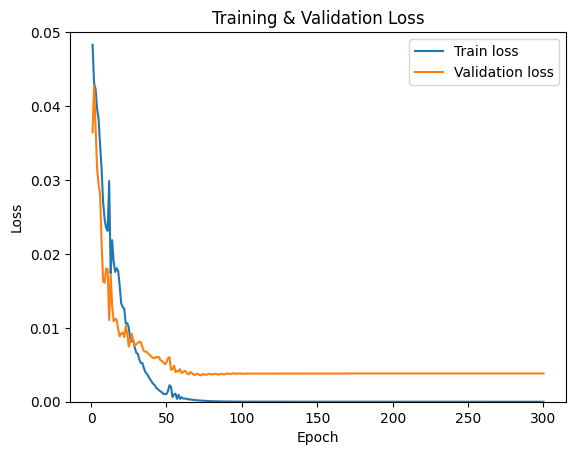

In [9]:
import math

plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.05)
plt.title('Training & Validation Loss')
plt.legend()
plt.savefig('./loss_curves/loss_curve.png')
plt.show()

### **| Evaluate Metrics: RMSE, MAPE, R^2**

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
y_true_1, y_pred_1 = [], []
y_true_2, y_pred_2 = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  # (batch, 2)
        outputs = model(images)      # (batch, 2)

        # Separate compliance1, compliance2
        y_true_1.extend(labels[:, 0].cpu().numpy())
        y_true_2.extend(labels[:, 1].cpu().numpy())
        y_pred_1.extend(outputs[:, 0].cpu().numpy())
        y_pred_2.extend(outputs[:, 1].cpu().numpy())

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

def mape(a, b):
    a, b = np.array(a), np.array(b)
    return np.mean(np.abs((a - b) / a)) * 100

y_true_1, y_pred_1 = np.array(y_true_1), np.array(y_pred_1)
y_true_2, y_pred_2 = np.array(y_true_2), np.array(y_pred_2)

compliance_min = np.array([29.07, 11.95])
compliance_max = np.array([189.90, 191.65])

y_true_1 = y_true_1 * (compliance_max[0] - compliance_min[0]) + compliance_min[0]
y_pred_1 = y_pred_1 * (compliance_max[0] - compliance_min[0]) + compliance_min[0]

y_true_2 = y_true_2 * (compliance_max[1] - compliance_min[1]) + compliance_min[1]
y_pred_2 = y_pred_2 * (compliance_max[1] - compliance_min[1]) + compliance_min[1]

rmse_1 = rmse(y_true_1, y_pred_1)
mape_1 = mape(y_true_1, y_pred_1)
r2_1 = r2_score(y_true_1, y_pred_1)

rmse_2 = rmse(y_true_2, y_pred_2)
mape_2 = mape(y_true_2, y_pred_2)
r2_2 = r2_score(y_true_2, y_pred_2)

print(f"Compliance1  RMSE: {rmse_1:.4f}, MAPE: {mape_1:.2f}%, R²: {r2_1:.4f}")
print(f"Compliance2  RMSE: {rmse_2:.4f}, MAPE: {mape_2:.2f}%, R²: {r2_2:.4f}")


Compliance1  RMSE: 10.6681, MAPE: 12.93%, R²: 0.9176
Compliance2  RMSE: 10.2353, MAPE: 19.44%, R²: 0.8319


### **| R^2 Plot (scatter of true vs. predicted)**

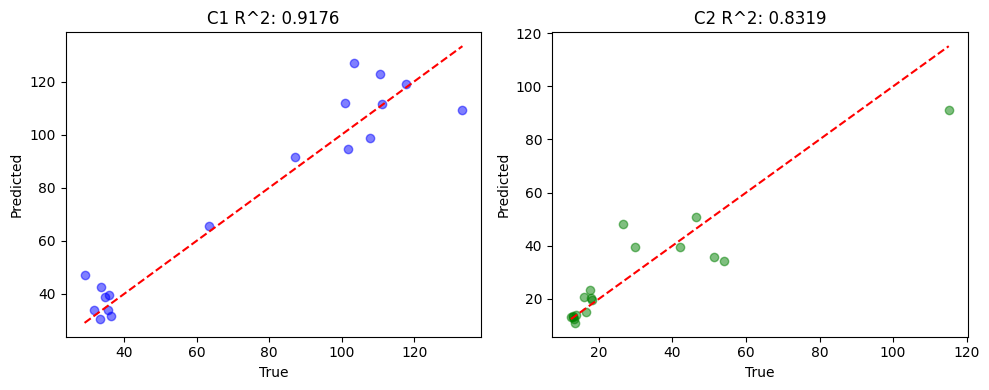

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(y_true_1, y_pred_1, c='blue', alpha=0.5, label='Compliance1')
axes[0].plot([min(y_true_1), max(y_true_1)], [min(y_true_1), max(y_true_1)], 'r--')
axes[0].set_title(f"C1 R^2: {r2_1:.4f}")
axes[0].set_xlabel("True")
axes[0].set_ylabel("Predicted")

axes[1].scatter(y_true_2, y_pred_2, c='green', alpha=0.5, label='Compliance2')
axes[1].plot([min(y_true_2), max(y_true_2)], [min(y_true_2), max(y_true_2)], 'r--')
axes[1].set_title(f"C2 R^2: {r2_2:.4f}")
axes[1].set_xlabel("True")
axes[1].set_ylabel("Predicted")

plt.tight_layout()
plt.savefig('./loss_curves/r2_scatter.png')
plt.show()


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

def modify_first_conv_to_1ch(model, model_name: str):
    if model_name in ["resnet18", "resnet34", "resnet50"]:
        old_conv = model.conv1
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias = old_conv.bias
        model.conv1 = new_conv

    elif model_name in ["efficientnet_b0", "efficientnet_b1"]:
        old_conv = model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias = old_conv.bias
        model.features[0][0] = new_conv

    else:
        raise ValueError(f"Unsupported model_name: {model_name}")
    return model


def get_pretrained_regressor(model_name="resnet18", num_outputs=2, pretrained=True):
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet18(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    elif model_name == "resnet34":
        weights = models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet34(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    elif model_name == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet50(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs),
        )

    elif model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.efficientnet_b0(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    elif model_name == "efficientnet_b1":
        weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.efficientnet_b1(weights=weights)
        model = modify_first_conv_to_1ch(model, model_name)
        in_feat = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs),
        )

    else:
        raise ValueError("model_name must be one of: resnet18/resnet34/resnet50/efficientnet_b0/efficientnet_b1")

    return model

In [13]:
MODEL_NAME = "resnet34"   # "resnet34", "resnet50", "efficientnet_b0", "efficientnet_b1"
USE_PRETRAINED = False

model = get_pretrained_regressor(
    model_name=MODEL_NAME,
    num_outputs=2,
    pretrained=USE_PRETRAINED
).to(device)

tv_lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=tv_lr, weight_decay=1e-4)

try:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
except Exception:
    scheduler = None

print("Torchvision regressor ready:", MODEL_NAME, "| pretrained:", USE_PRETRAINED)

Torchvision regressor ready: resnet34 | pretrained: False


In [14]:
import time
import numpy as np
import torch

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        if is_train:
            optimizer.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        n += bs

    return total_loss / max(n, 1)

TV_EPOCHS = 300

tv_train_losses, tv_val_losses = [], []
t0 = time.time()

for ep in range(1, TV_EPOCHS + 1):
    tr = run_epoch(model, train_loader, optimizer=optimizer)
    va = run_epoch(model, test_loader, optimizer=None)

    tv_train_losses.append(tr)
    tv_val_losses.append(va)

    if scheduler is not None:
        scheduler.step()

    if ep == 1 or ep % 10 == 0:
        print(f"[{MODEL_NAME}] epoch {ep:3d}/{TV_EPOCHS} | train {tr:.6f} | test {va:.6f}")

print("Done. elapsed:", time.time() - t0, "sec")

# ---- cache torchvision model for later comparison ----
tv_model = model


[resnet34] epoch   1/300 | train 0.213275 | test 0.208162
[resnet34] epoch  10/300 | train 0.018312 | test 1.417255
[resnet34] epoch  20/300 | train 0.006760 | test 0.099388
[resnet34] epoch  30/300 | train 0.003936 | test 0.075028
[resnet34] epoch  40/300 | train 0.004159 | test 0.014420
[resnet34] epoch  50/300 | train 0.004468 | test 0.006087
[resnet34] epoch  60/300 | train 0.002396 | test 0.004343
[resnet34] epoch  70/300 | train 0.002542 | test 0.004359
[resnet34] epoch  80/300 | train 0.001741 | test 0.004319
[resnet34] epoch  90/300 | train 0.001908 | test 0.006149
[resnet34] epoch 100/300 | train 0.001413 | test 0.003975
[resnet34] epoch 110/300 | train 0.001335 | test 0.004605
[resnet34] epoch 120/300 | train 0.001460 | test 0.004163
[resnet34] epoch 130/300 | train 0.001043 | test 0.003960
[resnet34] epoch 140/300 | train 0.002136 | test 0.004214
[resnet34] epoch 150/300 | train 0.000944 | test 0.004162
[resnet34] epoch 160/300 | train 0.001206 | test 0.004012
[resnet34] epo

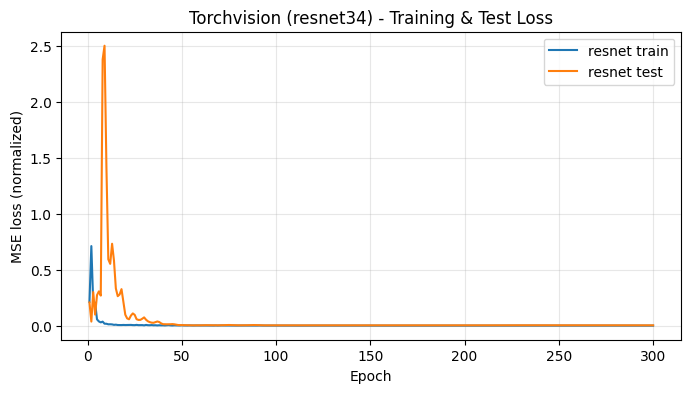

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(1, len(tv_train_losses)+1), tv_train_losses, label="resnet train")
plt.plot(range(1, len(tv_val_losses)+1), tv_val_losses, label="resnet test")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (normalized)")
plt.title(f"Torchvision ({MODEL_NAME}) - Training & Test Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

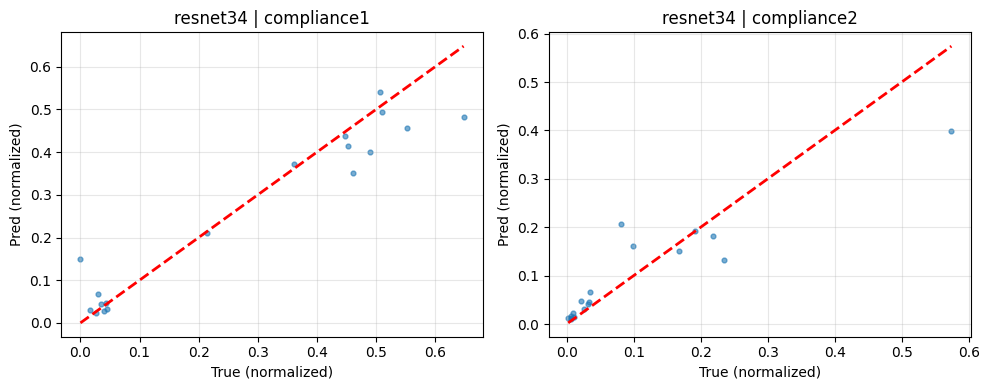

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch

tv_model.eval()

y_true_list, y_pred_list = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = tv_model(x).cpu().numpy()
        y_true = y.numpy()
        y_true_list.append(y_true)
        y_pred_list.append(pred)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for k in range(2):
    axes[k].scatter(y_true[:, k], y_pred[:, k], s=12, alpha=0.6)
    lo = min(y_true[:, k].min(), y_pred[:, k].min())
    hi = max(y_true[:, k].max(), y_pred[:, k].max())
    axes[k].plot([lo, hi], [lo, hi], "r--", linewidth=2)
    axes[k].set_title(f"{MODEL_NAME} | compliance{k+1}")
    axes[k].set_xlabel("True (normalized)")
    axes[k].set_ylabel("Pred (normalized)")
    axes[k].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, r2_score

def denorm(y_norm, labels_min, labels_max):
    # y_norm: (N,2) normalized to [0,1]
    return y_norm * (labels_max - labels_min) + labels_min

def eval_metrics(model_, loader_, labels_min, labels_max):
    model_.eval()
    y_true_list, y_pred_list = [], []

    with torch.no_grad():
        for x, y in loader_:
            x = x.to(device)
            pred = model_(x).detach().cpu().numpy()
            y_true = y.detach().cpu().numpy()
            y_true_list.append(y_true)
            y_pred_list.append(pred)

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    y_true_dn = denorm(y_true, labels_min, labels_max)
    y_pred_dn = denorm(y_pred, labels_min, labels_max)

    out = {}
    for k in range(2):
        rmse = np.sqrt(mean_squared_error(y_true_dn[:, k], y_pred_dn[:, k]))
        mape = np.mean(np.abs((y_true_dn[:, k] - y_pred_dn[:, k]) / (y_true_dn[:, k] + 1e-8))) * 100
        r2 = r2_score(y_true_dn[:, k], y_pred_dn[:, k])
        out[f"c{k+1}_rmse"] = rmse
        out[f"c{k+1}_mape"] = mape
        out[f"c{k+1}_r2"] = r2

    return out, (y_true_dn, y_pred_dn)

## 6) Compare Baseline CNN vs Torchvision (ResNet)


,Model,c1_rmse,c1_mape,c1_r2,c2_rmse,c2_mape,c2_r2
0,Baseline CNN,10.6680,12.93,0.9176,10.2354,19.44,0.8319
1,Torchvision (resnet34),11.0211,11.61,0.9121,10.7973,19.84,0.8129


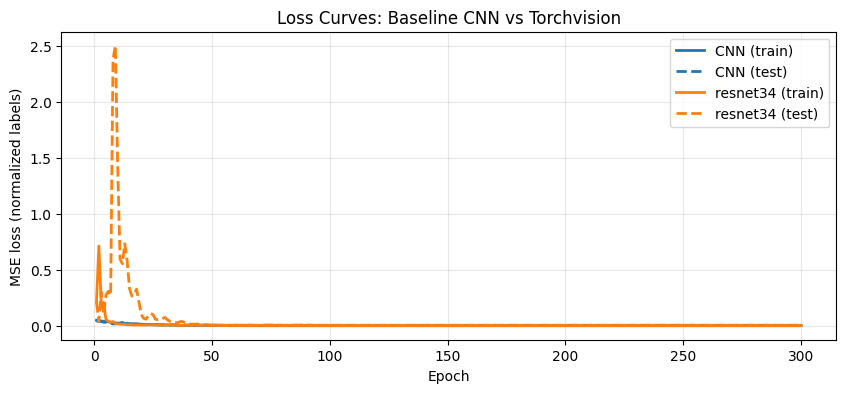

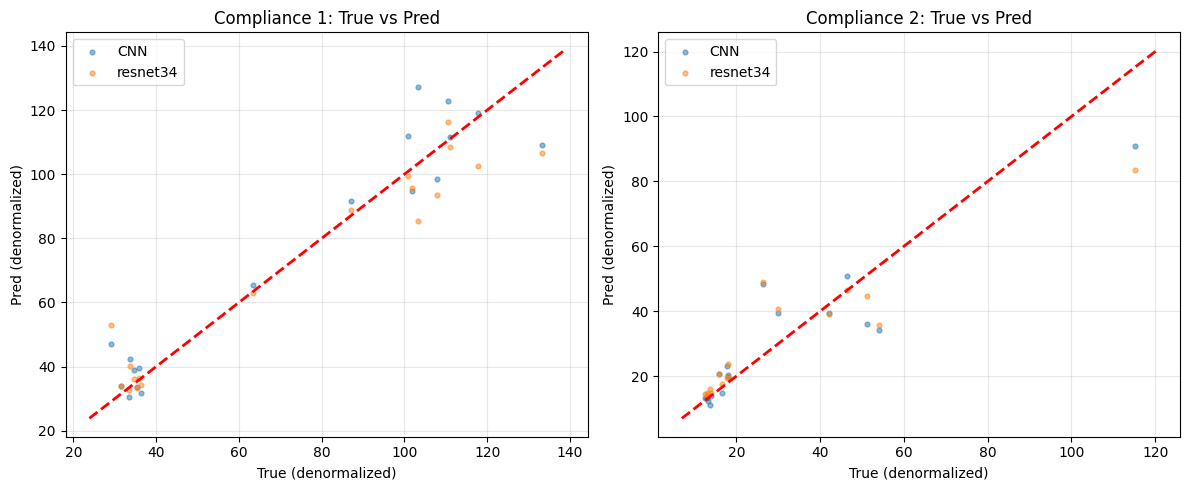

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# labels_min/max from the dataset (used for denormalization)
labels_min = full_dataset.labels_min
labels_max = full_dataset.labels_max

# Compute metrics + cache predictions (denormalized)
m_cnn, (cnn_true, cnn_pred) = eval_metrics(cnn_model, test_loader, labels_min, labels_max)
m_tv,  (tv_true,  tv_pred)  = eval_metrics(tv_model,  test_loader, labels_min, labels_max)

df = pd.DataFrame([
    {"Model": "Baseline CNN", **m_cnn},
    {"Model": f"Torchvision ({MODEL_NAME})", **m_tv},
])

# Pretty display
display(df.style.format({
    "c1_rmse": "{:.4f}", "c2_rmse": "{:.4f}",
    "c1_mape": "{:.2f}", "c2_mape": "{:.2f}",
    "c1_r2": "{:.4f}", "c2_r2": "{:.4f}",
}))

# ---- Loss curve comparison ----
plt.figure(figsize=(10,4))
cnn_color = "tab:blue"
tv_color  = "tab:orange"

# ---- CNN ----
plt.plot(
    range(1, len(cnn_train_losses)+1),
    cnn_train_losses,
    color=cnn_color,
    linestyle="-",              # solid = train
    linewidth=2,
    label="CNN (train)"
)

plt.plot(
    range(1, len(cnn_val_losses)+1),
    cnn_val_losses,
    color=cnn_color,
    linestyle="--",             # dashed = test
    linewidth=2,
    label="CNN (test)"
)

# ---- Torchvision model ----
plt.plot(
    range(1, len(tv_train_losses)+1),
    tv_train_losses,
    color=tv_color,
    linestyle="-",
    linewidth=2,
    label=f"{MODEL_NAME} (train)"
)

plt.plot(
    range(1, len(tv_val_losses)+1),
    tv_val_losses,
    color=tv_color,
    linestyle="--",
    linewidth=2,
    label=f"{MODEL_NAME} (test)"
)
plt.xlabel("Epoch")
plt.ylabel("MSE loss (normalized labels)")
plt.title("Loss Curves: Baseline CNN vs Torchvision")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# ---- Scatter comparison (True vs Pred) ----
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def scatter(ax, y_true, y_pred, label):
    ax.scatter(y_true, y_pred, s=12, alpha=0.5, label=label)

# compliance1
scatter(axes[0], cnn_true[:,0], cnn_pred[:,0], "CNN")
scatter(axes[0], tv_true[:,0],  tv_pred[:,0],  MODEL_NAME)

# compliance2
scatter(axes[1], cnn_true[:,1], cnn_pred[:,1], "CNN")
scatter(axes[1], tv_true[:,1],  tv_pred[:,1],  MODEL_NAME)

for k in range(2):
    lo = min(axes[k].get_xlim()[0], axes[k].get_ylim()[0])
    hi = max(axes[k].get_xlim()[1], axes[k].get_ylim()[1])
    axes[k].plot([lo, hi], [lo, hi], "r--", linewidth=2)
    axes[k].set_xlabel("True (denormalized)")
    axes[k].set_ylabel("Pred (denormalized)")
    axes[k].grid(True, alpha=0.3)
    axes[k].legend()

axes[0].set_title("Compliance 1: True vs Pred")
axes[1].set_title("Compliance 2: True vs Pred")
plt.tight_layout()
plt.show()